# Signal extraction

Let's see if we can decrease the size of the AIRS-CH0 data by selecting just the pixels that have signal. My idea is to sum across the image and take the ~3 or so rows that give the highest sum.

## Notebook set-up

Working directory: /mnt/arkk/kaggle/ariel-data-challenge


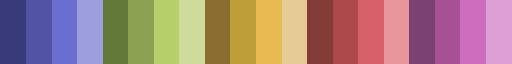

In [1]:
# Set notebook root to project root
from helper_functions import set_project_root

set_project_root()

# Standard library imports
from pathlib import Path

# Third party imports
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import colormaps as cm
from matplotlib.ticker import FormatStrFormatter

# Local imports
import configuration as config

# Make sure the figures directory exists
figures_dir = f'{config.FIGURES_DIRECTORY}/signal_extraction'
Path(figures_dir).mkdir(parents=True, exist_ok=True)

colormap = cm.get_cmap('tab20b')
colors = colormap.colors

# Set some colors for plotting
blue = colors[0]
light_blue = colors[1]
green = colors[4]
yellow = colors[9]
red = colors[13]
light_red = colors[14]
purple = colors[16]

transit_color = blue
spectrum_color = red
colormap

## 1. Load test frame

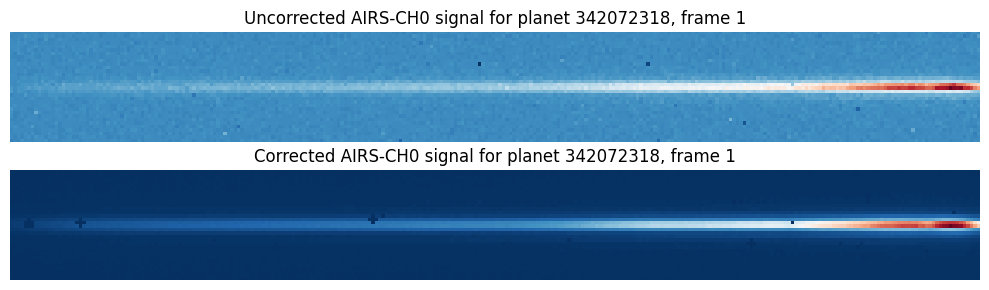

In [2]:
# Load uncorrected AIRS-CH0 signal test planet
planet_path = f'{config.RAW_DATA_DIRECTORY}/train/{config.SAMPLE_PLANET}'

uncorrected_airs_signal = pd.read_parquet(
    f'{planet_path}/AIRS-CH0_signal_0.parquet'
).to_numpy().reshape(11250, 32, 356)[:, :, 39:321]

# Load corrected data for same planet
with h5py.File(f'{config.SIGNAL_CORRECTED_DIRECTORY}/train.h5', 'r') as hdf:
    corrected_airs_signal = hdf[config.SAMPLE_PLANET]['AIRS-CH0_signal'][:]

# Plot the first frame of each
uncorrected_frame = uncorrected_airs_signal[0]
uncorrected_frame = uncorrected_frame.astype(float) / np.mean(uncorrected_frame.astype(float))
corrected_frame = corrected_airs_signal[0]

fig, axs = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 3))

axs[0].set_title(f'Uncorrected AIRS-CH0 signal for planet {config.SAMPLE_PLANET}, frame 1')
axs[0].imshow(uncorrected_frame, cmap='RdBu_r')
axs[0].axis('off')

axs[1].set_title(f'Corrected AIRS-CH0 signal for planet {config.SAMPLE_PLANET}, frame 1')
axs[1].imshow(corrected_frame, cmap='RdBu_r')
axs[1].axis('off')

fig.tight_layout()
fig.savefig(f'{figures_dir}/02.3-corrected_vs_uncorrected_frames.jpg', dpi=config.STD_FIG_DPI, bbox_inches='tight')

Weird, the hot/dead pixel masking makes it seem like these are not the same frames. But they are. They should be... Maybe need to remember here, this is synthetic data. Could be that the hot/dead pixels were just thrown in randomly? I dunno, let's come back to this later.

## 2. Total flux by frame y-index

In [3]:
# Sum the frames' rows
uncorrected_frame_sum = np.sum(uncorrected_frame, axis=1)
corrected_frame_sum = np.sum(corrected_frame, axis=1)

# Standardize the sums
uncorrected_frame_sum = (uncorrected_frame_sum - np.mean(uncorrected_frame_sum)) / np.std(uncorrected_frame_sum)
corrected_frame_sum = (corrected_frame_sum - np.mean(corrected_frame_sum)) / np.std(corrected_frame_sum)

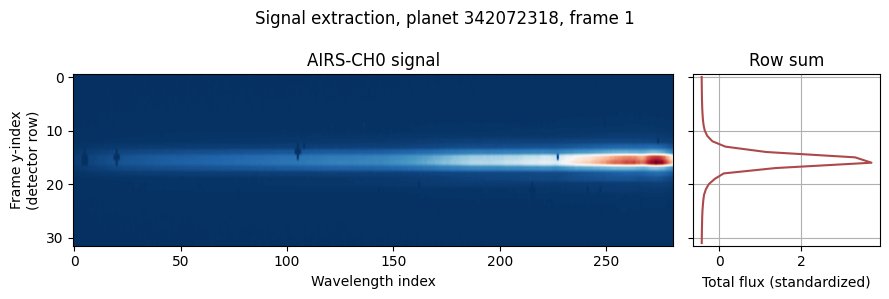

In [4]:
fig = plt.figure(figsize=(config.STD_FIG_WIDTH * 1.5, config.STD_FIG_WIDTH/2))

fig.suptitle(f'Signal extraction, planet {config.SAMPLE_PLANET}, frame 1')

gs = fig.add_gridspec(1,4)
ax1 = fig.add_subplot(gs[0, :3])
ax2 = fig.add_subplot(gs[0, 3], sharey=ax1)
plt.setp(ax2.get_yticklabels(), visible=False)

ax1.set_title(f'AIRS-CH0 signal')
ax1.imshow(corrected_frame, aspect='auto', cmap='RdBu_r')
ax1.set_xlabel('Wavelength index')
ax1.set_ylabel('Frame y-index\n(detector row)')

ax2.set_title('Row sum')
ax2.plot(
    corrected_frame_sum,
    range(len(corrected_frame_sum)),
    color=red
)

ax2.set_xlabel('Total flux (standardized)')
ax2.grid()

fig.tight_layout()
fig.savefig(
    f'{figures_dir}/02.3-total_flux_by_row_spectrogram.jpg',
    dpi=config.STD_FIG_DPI, bbox_inches='tight'
)

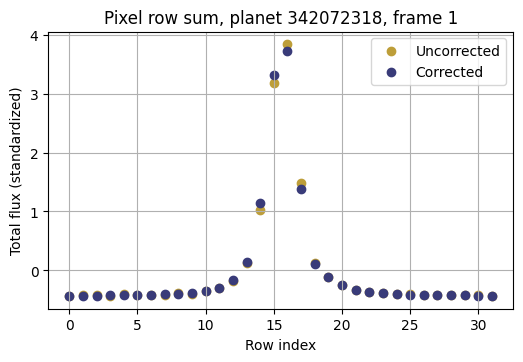

In [5]:
plt.figure(figsize=(config.STD_FIG_WIDTH, config.STD_FIG_WIDTH * 0.6))
plt.scatter(
    range(len(uncorrected_frame_sum)),
    uncorrected_frame_sum, color=yellow,
    label='Uncorrected'
)

plt.scatter(
    range(len(corrected_frame_sum)),
    corrected_frame_sum,
    color=blue,
    label='Corrected'
)

plt.xlabel('Row index')
plt.ylabel('Total flux (standardized)')
plt.title(f'Pixel row sum, planet {config.SAMPLE_PLANET}, frame 1')
plt.legend()
plt.grid()
plt.savefig(
    f'{figures_dir}/02.3-total_flux_by_row.jpg',
    dpi=config.STD_FIG_DPI, bbox_inches='tight'
)
plt.show()

Wow, well, that's an interesting result right there - the corrected frame looks cleaner as an image, but after standardization the total signal across rows is almost identical to the uncorrected frame.

The part of the frame that actually contains the signal is clearly between pixels 10 and 20. The highest signal rows look like 14, 15, 16 and 17. We can definitely pull them out, no problem. Let's take a look.

## 3. Signal 'strip': brightest rows

I think what we should do is average or sum the top few rows and just take that forward as the 'signal'. Doing so will give us a huge data reduction. Question is - does the signal move around during the time course of exposures? It seems like in real telescope data, it would. But maybe in this synthetic dataset it doesn't. If it doesn't, we just need to look at one frame per planet, pick the rows, and then slice them out of the whole sequence. Easy. If it does move, we need to check the row sums in each frame. We can probably do that with some Numpy indexing and slicing, but it might involve a loop, so I'd rather not if I don't have to.

Let's try summing the same top four brightest rows in all frames and then make the exoplanet transit plot for the signal strip and the total data. If the plot looks wonky, we know the signal probably moved.

In [6]:
n_rows = 4

# Sum across axis 2
row_sums = np.sum(corrected_airs_signal, axis=2)

# Get top n rows for each frame
top_rows = np.argsort(row_sums, axis=1)[:, -n_rows:]

# Now index the original array to get the top rows for each frame
signal_strip = corrected_airs_signal[:, top_rows[1], :]

# Sum the top rows per frame
signal_strip = np.sum(signal_strip, axis=1)

# Calculate total flux for each frame
total_flux = [np.sum(frame) for frame in corrected_airs_signal]

# Calculate total flux in the averaged signal strip for each frame
total_strip_flux = [np.sum(frame) for frame in signal_strip]

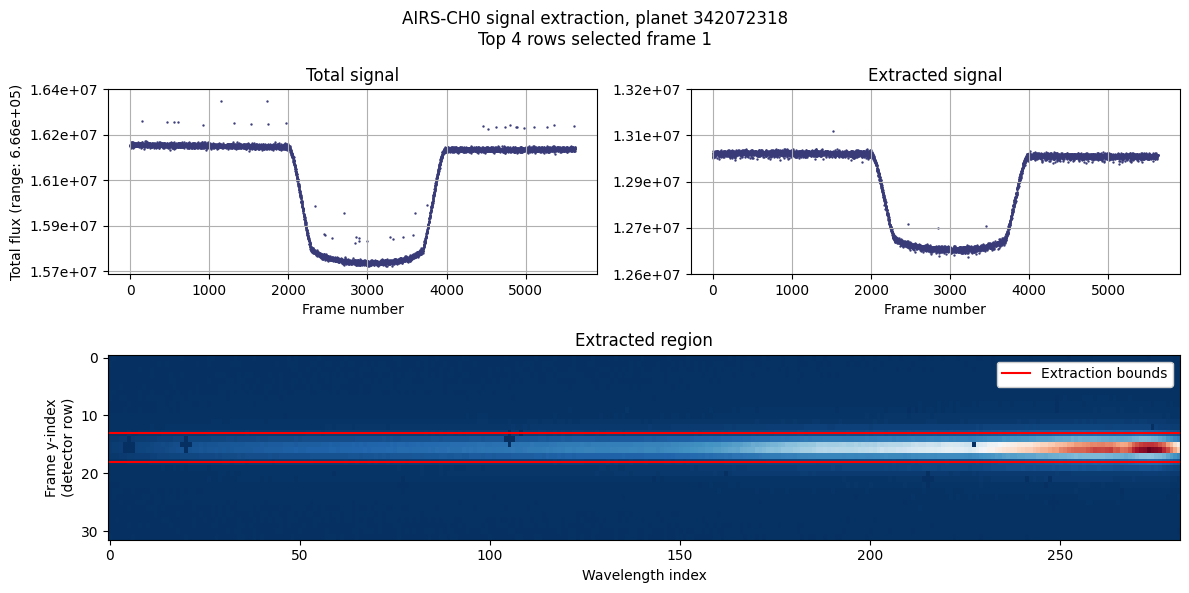

In [7]:
fig = plt.figure(figsize=(config.STD_FIG_WIDTH * 2, config.STD_FIG_WIDTH))

fig.suptitle(f'AIRS-CH0 signal extraction, planet {config.SAMPLE_PLANET}\nTop {n_rows} rows selected frame 1')

gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

ax1.set_title(f'Total signal')
ax1.scatter(list(range(len(total_flux))), total_flux, color=transit_color, s=0.5)
ax1.set_xlabel('Frame number')

y_lims = ax1.get_ylim()
y_range = y_lims[1] - y_lims[0]
data_mean = np.mean(total_flux)
y_start = data_mean - y_range/2
y_end = data_mean + y_range/2

ax1.set_yticks(np.round(np.linspace(y_start, y_end, 5), 2))
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2e'))
ax1.set_ylabel(f'Total flux (range: {y_range:.2e})')
ax1.grid()

ax2.set_title(f'Extracted signal')
ax2.scatter(list(range(len(total_strip_flux))), total_strip_flux, color=transit_color, s=0.5)
ax2.set_xlabel('Frame number')
ax2.grid()

data_mean = np.mean(total_strip_flux)
y_start = data_mean - y_range/2
y_end = data_mean + y_range/2

ax2.set_yticks(np.linspace(y_start, y_end, 5))
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2e'))

ax3.set_title(f'Extracted region')
ax3.imshow(corrected_frame, aspect='auto', cmap='RdBu_r')
ax3.axhline(y=np.max(top_rows[0]) + 1, color='red', linestyle='-')
ax3.axhline(y=np.min(top_rows[0]) - 1, color='red', linestyle='-', label='Extraction bounds')
ax3.set_xlabel('Wavelength index')
ax3.set_ylabel('Frame y-index\n(detector row)')
ax3.legend(framealpha=1)
fig.tight_layout()

fig.savefig(
    f'{figures_dir}/02.3-transit_plot_total_vs_strip_background_corrected.jpg',
    dpi=config.STD_FIG_DPI,
    bbox_inches='tight')

It definitely doesn't look like the signal wandered off over the course of the time series. But the slight increase in noise when summing the strip relative to the input data makes me think that maybe it is moving around a bit or something. It makes sense that in real data, when satellite drifts or the star moves, the alignment camera brings it back, resulting in the signal floating around a bit? Don't know.

In [8]:
starting_size = corrected_frame.shape[0] * corrected_frame.shape[1] * corrected_airs_signal.shape[0]
extracted_size = signal_strip.shape[0] * signal_strip.shape[1]

print(f'Size of the dataset before extraction: {starting_size} pixels')
print(f'Size of the dataset after extraction: {extracted_size} pixels')

print(f'Data reduction factor: {starting_size / extracted_size:.1f}x')

Size of the dataset before extraction: 50760000 pixels
Size of the dataset after extraction: 1586250 pixels
Data reduction factor: 32.0x


Killer result - we should probably be doing this before the preprocessing. I bet we could get the pipeline runtime down to minutes instead of hours! But, I want to try a few more things before we go implement that. Let's select the top four rows individually in each image and see what that does. And let's do it without a loop, if possible.

In [9]:
# Sum across axis 2
row_sums = np.sum(corrected_airs_signal, axis=2)

# Get top n rows for each frame
top_rows = np.argsort(row_sums, axis=1)[:, -n_rows:]

# Now index the original array to get the top rows for each frame
signal_strip = corrected_airs_signal[:, top_rows[1], :]

# And finally average across the rows to get a 1D signal per frame  
signal_strip = np.sum(signal_strip, axis=1)

# Sum the strip flux for each frame
total_strip_flux = [np.sum(frame) for frame in signal_strip]

Geesh, that wasn't so bad after all - thanks Numpy! No loops, just indexing and slicing. How `bout now?

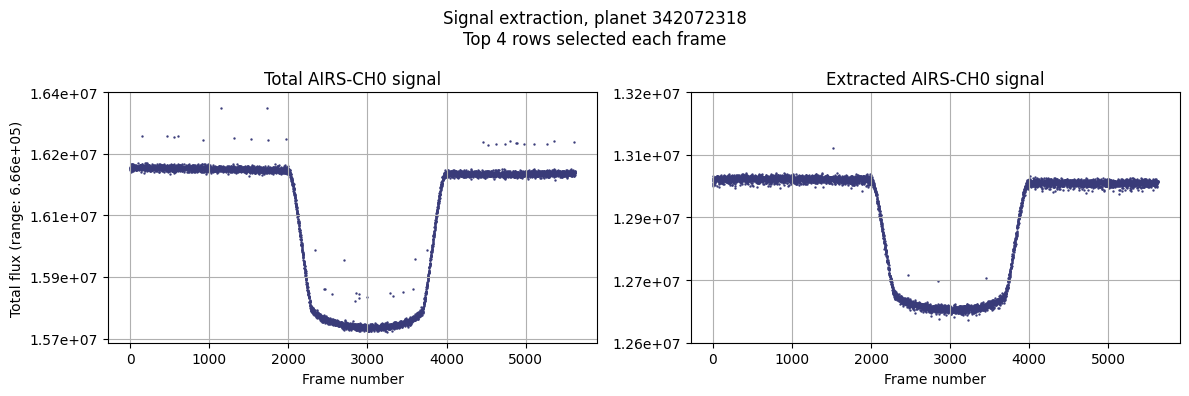

In [10]:
fig, axs = plt.subplots(1,2, figsize=(config.STD_FIG_WIDTH * 2, config.STD_FIG_WIDTH - 2))
fig.suptitle(f'Signal extraction, planet {config.SAMPLE_PLANET}\nTop {n_rows} rows selected each frame')


axs[0].set_title(f'Total AIRS-CH0 signal')
axs[0].scatter(list(range(len(total_flux))), total_flux, color=transit_color, s=0.5)
axs[0].set_xlabel('Frame number')
axs[0].grid()

y_lims = axs[0].get_ylim()
y_range = y_lims[1] - y_lims[0]
data_mean = np.mean(total_flux)
y_start = data_mean - y_range/2
y_end = data_mean + y_range/2

axs[0].set_yticks(np.round(np.linspace(y_start, y_end, 5), 2))
axs[0].yaxis.set_major_formatter(FormatStrFormatter('%.2e'))
axs[0].set_ylabel(f'Total flux (range: {y_range:.2e})')


axs[1].set_title(f'Extracted AIRS-CH0 signal')
axs[1].scatter(list(range(len(total_strip_flux))), total_strip_flux, color=transit_color, s=0.5)
axs[1].set_xlabel('Frame number')
axs[1].grid()

data_mean = np.mean(total_strip_flux)
y_start = data_mean - y_range/2
y_end = data_mean + y_range/2

axs[1].set_yticks(np.linspace(y_start, y_end, 5))
axs[1].yaxis.set_major_formatter(FormatStrFormatter('%.2e'))


fig.tight_layout()
fig.savefig(
    f'{figures_dir}/02.3-transit_plot_total_vs_strip_each_frame.jpg',
    dpi=config.STD_FIG_DPI,
    bbox_inches='tight'
)

That did nothing - looking at the points closely, I can tell this plot is the same as the first one.

I have another idea - let's try subtracting a background strip, where the signal isn't, from each frame. How about we take two background strips and average them, say at pixels 4 and 5 and 25 and 26, so the same number of pixels as are aggregated in the signal strip but above and below the signal strip in the frame.

## 4. Frame background correction

In [11]:
# Get average background strip
background_strip = corrected_airs_signal[:, [4, 5, 25, 26], :]
background_strip = np.sum(background_strip, axis=1)
total_background_flux = np.sum(background_strip, axis=1)

# Subtract from the signal strip
corrected_signal_strip = signal_strip - background_strip
total_strip_flux = np.sum(corrected_signal_strip, axis=1)

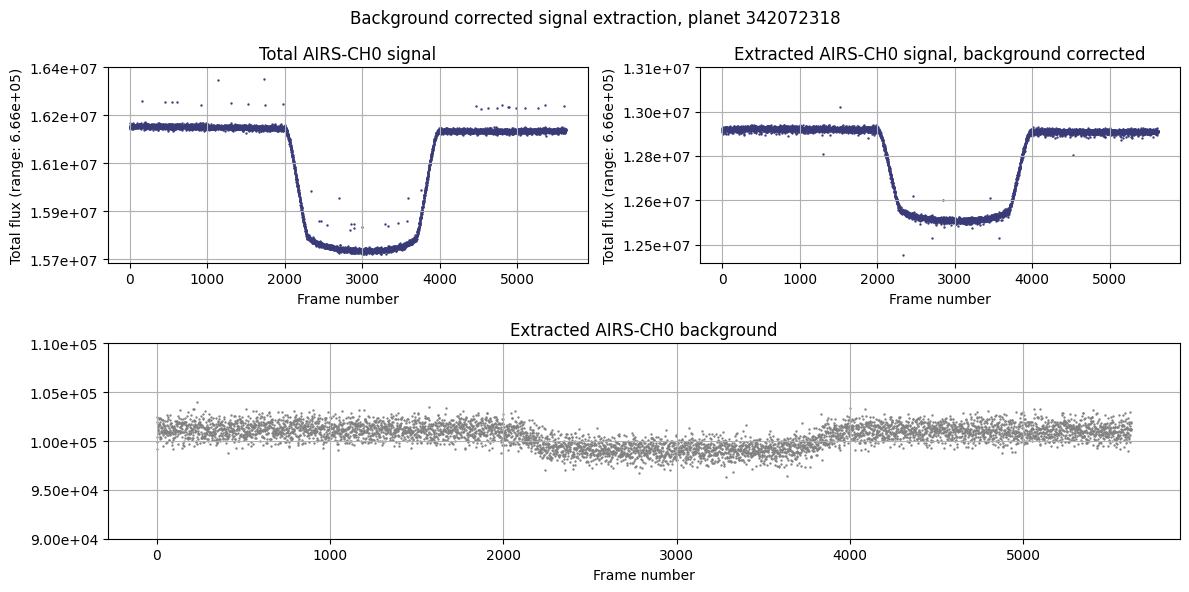

In [12]:
fig = plt.figure(figsize=(config.STD_FIG_WIDTH * 2, config.STD_FIG_WIDTH))

fig.suptitle(f'Background corrected signal extraction, planet {config.SAMPLE_PLANET}')

gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

ax1.set_title(f'Total AIRS-CH0 signal')
ax1.scatter(list(range(len(total_flux))), total_flux, color=transit_color, s=0.5)
ax1.set_xlabel('Frame number')

y_lims = ax1.get_ylim()
y_range = y_lims[1] - y_lims[0]
data_mean = np.mean(total_flux)
y_start = data_mean - y_range/2
y_end = data_mean + y_range/2

ax1.set_yticks(np.round(np.linspace(y_start, y_end, 5), 2))
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2e'))
ax1.set_ylabel(f'Total flux (range: {y_range:.2e})')
ax1.grid()

ax2.set_title(f'Extracted AIRS-CH0 signal, background corrected')
ax2.scatter(list(range(len(total_strip_flux))), total_strip_flux, color=transit_color, s=0.5)
ax2.set_xlabel('Frame number')

data_mean = np.mean(total_strip_flux)
y_start = data_mean - y_range/2
y_end = data_mean + y_range/2

ax2.set_yticks(np.linspace(y_start, y_end, 5))
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2e'))
ax2.set_ylabel(f'Total flux (range: {y_range:.2e})')
ax2.grid()

ax3.set_title(f'Extracted AIRS-CH0 background')

ax3.scatter(list(range(len(total_background_flux))), total_background_flux, color='gray', s=0.5)
ax3.set_xlabel('Frame number')
ax3.set_ylim(90000, 110000)
ax3.yaxis.set_major_formatter(FormatStrFormatter('%.2e'))
ax3.grid()

fig.tight_layout()

fig.savefig(
    f'{figures_dir}/02.3-transit_plot_total_vs_strip_background_corrected.jpg',
    dpi=config.STD_FIG_DPI,
    bbox_inches='tight')

The strip signal still looks a tiny bit more noisy, and we have introduced a few low outliers. These should be easy to threshold out, if we decide we want to use this approach.

**Results so far**

1. Summing the top few brightest rows preserves the transit signal beautifully.
2. The top rows for a planet can be selected by looking at the first frame only.
3. Subtracting a per-frame background from the signal strip is not necessary.

Let's remember the goal here - we are going for data reduction without loss of signal, and I think we accomplished that already! Here's the size of the dataset before and after extraction of the top 4 brightest rows:

In [13]:
starting_size = corrected_frame.shape[0] * corrected_frame.shape[1] * corrected_airs_signal.shape[0]
extracted_size = signal_strip.shape[0] * signal_strip.shape[1]

print(f'Size of the dataset before extraction: {starting_size} pixels')
print(f'Size of the dataset after extraction: {extracted_size} pixels')

print(f'Data reduction factor: {starting_size / extracted_size:.1f}x')

Size of the dataset before extraction: 50760000 pixels
Size of the dataset after extraction: 1586250 pixels
Data reduction factor: 32.0x


Let's try a few different strategies for selecting the rows to include in the strip - how many do we need to include? This decision could be made per-star. First, let's look at a bunch of rows individually and see how the signal changes as we move away from the brightest row. This is without the background subtraction.

## 5. Top rows by brightness: spectra

In [14]:
# Number of rows to extract
n_rows = 11

# Get the sorted indices of the rows based on the total flux
corrected_indices = np.argsort(corrected_frame_sum)

# Take the top n rows in descending order
top_rows = corrected_indices[-n_rows:][::-1]

OK, I take it back - the corrected signal appears much less noisy. Interestingly, the overall subjective noise seems to be a function of the total signal. Lower total signal across the row means more noise. Rows 20, 21 and 11 are the dimmest and their raw data also has the most jitter, followed in order by row 12.

Looks like the noise in the uncorrected signal really starts to come in after the 4th brightest row. Looking at the total brightness plot and the images, this makes sense - this is where the signal has really dropped off.

Let's make the transit plot for the same rows:

## 6. Top rows by brightness: transits

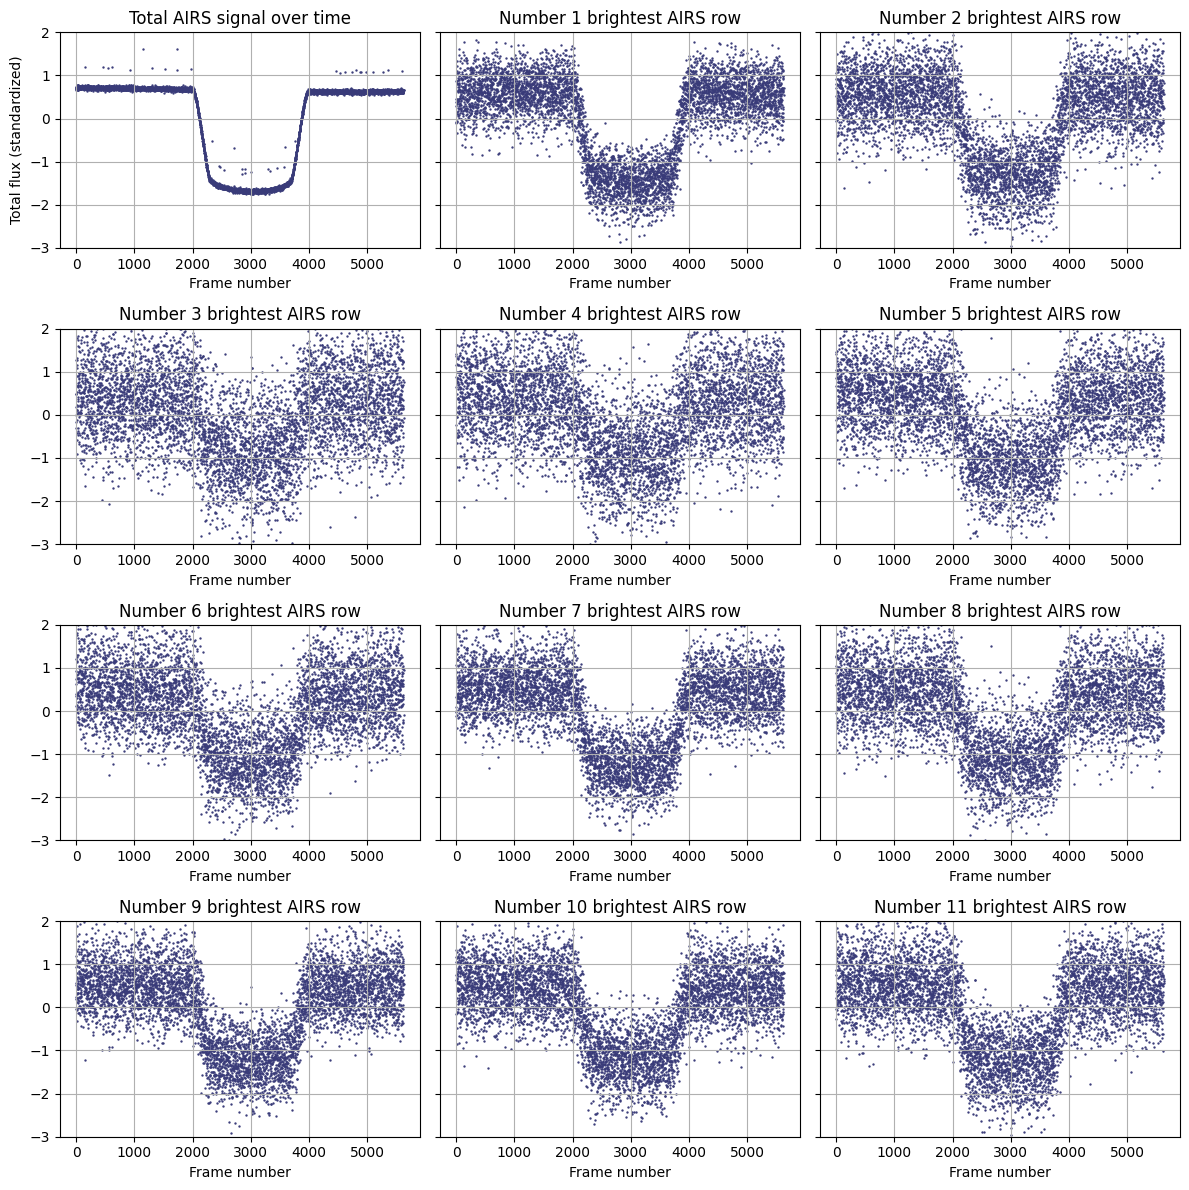

In [15]:
fig, axs = plt.subplots(4, 3, sharey=True, figsize=(config.STD_FIG_WIDTH * 2, config.STD_FIG_WIDTH * 2))
axs = axs.flatten()

standardized_total_flux = (total_flux - np.mean(total_flux)) / np.std(total_flux)

axs[0].set_title(f'Total AIRS signal over time')
axs[0].scatter(list(range(len(standardized_total_flux))), standardized_total_flux, color=transit_color, s=0.5)
axs[0].set_ylim(-3, 2)
axs[0].set_xlabel('Frame number')
axs[0].set_ylabel('Total flux (standardized)')
axs[0].grid()

for i, row in enumerate(top_rows):

    signal_strip = corrected_airs_signal[:, row, :]

    total_strip_flux = [np.sum(frame) for frame in signal_strip]
    total_strip_flux = (total_strip_flux - np.mean(total_strip_flux)) / np.std(total_strip_flux)

    axs[i+1].set_title(f'Number {i + 1} brightest AIRS row')
    axs[i+1].scatter(list(range(len(total_strip_flux))), total_strip_flux, color=transit_color, s=0.5)
    axs[i+1].set_xlabel('Frame number')
    axs[i+1].grid()

    if i + 1 % 3 == 0:
        axs[i+1].set_ylabel('Total flux (standardized)')

fig.savefig(f'{figures_dir}/02.3-top_n_rows_transit.jpg', dpi=config.STD_FIG_DPI, bbox_inches='tight')
fig.tight_layout()

Ok - so single rows are messy relative to summed rows or the total signal, and the noise seems to increase then decrease slightly as we work our way down the total flux ranking. It kinda bothers me that this is the case, I don't have a good explanation. When I combined rows, I used the sum, not the average - it seems to suggest that the noise in the rows is correlated (or anti-correlated). Such that when you add them up they sum to the same-ish amount of total flux across the frames. That feels like a synthetic data artifact - but I guess it might be some property of the detector?

Last thing to try - lets see how things look if we sum different numbers of rows. Also try standardizing each row before summing.

## 7. Top row sums: spectra

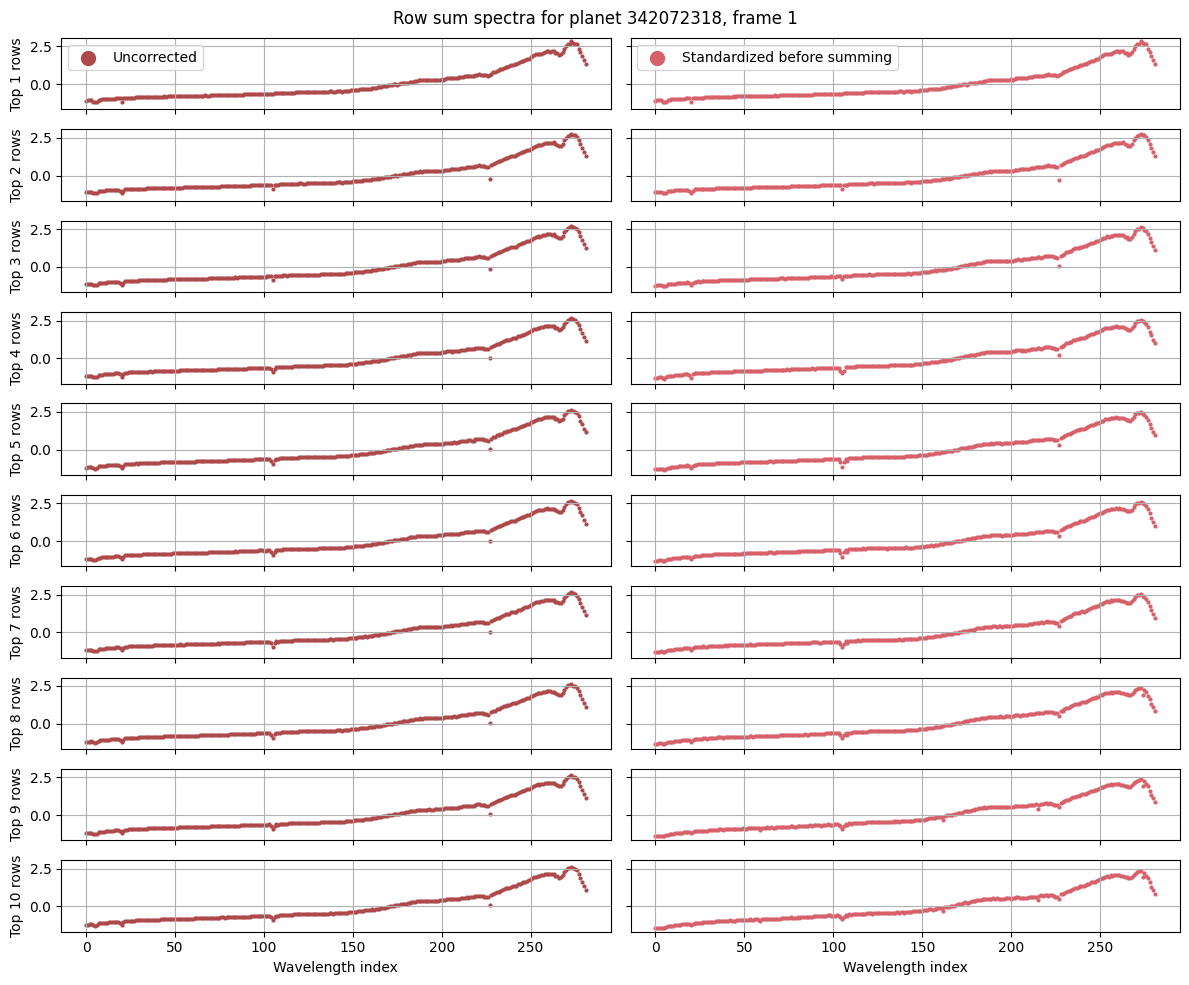

In [16]:
row_nums = [1,2,3,4,5,6,7,8,9,10]

fig, axs = plt.subplots(
    len(row_nums),
    2,
    sharex=True,
    sharey=True,
    figsize=(config.STD_FIG_WIDTH * 2, len(row_nums) * (config.STD_FIG_WIDTH / 6))
)

fig.suptitle(f'Row sum spectra for planet {config.SAMPLE_PLANET}, frame 1')

for i, n_rows in enumerate(row_nums):

    row_signals = corrected_frame[top_rows[:n_rows], :]
    standardized_row_signals = (
        row_signals - np.mean(row_signals, axis=1, keepdims=True)
    ) / np.std(row_signals, axis=1, keepdims=True)

    row_signals = np.sum(row_signals, axis=0)
    standardized_row_signals = np.sum(standardized_row_signals, axis=0)

    row_signals = (row_signals - np.mean(row_signals)) / np.std(row_signals)
    standardized_row_signals = (
        standardized_row_signals - np.mean(standardized_row_signals)
    ) / np.std(standardized_row_signals)

    axs[i,0].scatter(
        range(len(row_signals)),
        row_signals,
        color=spectrum_color,
        s=4,
        label='Uncorrected'
    )

    axs[i,1].scatter(
        range(len(standardized_row_signals)),
        standardized_row_signals,
        color=light_red,
        s=4,
        label='Standardized before summing'
    )

    axs[i,0].set_ylabel(f'Top {n_rows} rows')
    axs[i,0].grid()
    axs[i,1].grid()

axs[0,0].legend(loc='upper left', markerscale=5)
axs[0,1].legend(loc='upper left', markerscale=5)
axs[-1,0].set_xlabel('Wavelength index')
axs[-1,1].set_xlabel('Wavelength index')

fig.tight_layout()
fig.savefig(
    f'{figures_dir}/02.3-top_{len(row_nums)}_rows_summed_spectrum.jpg',
    dpi=config.STD_FIG_DPI,
    bbox_inches='tight'
)

## 8. Top row sums: transits

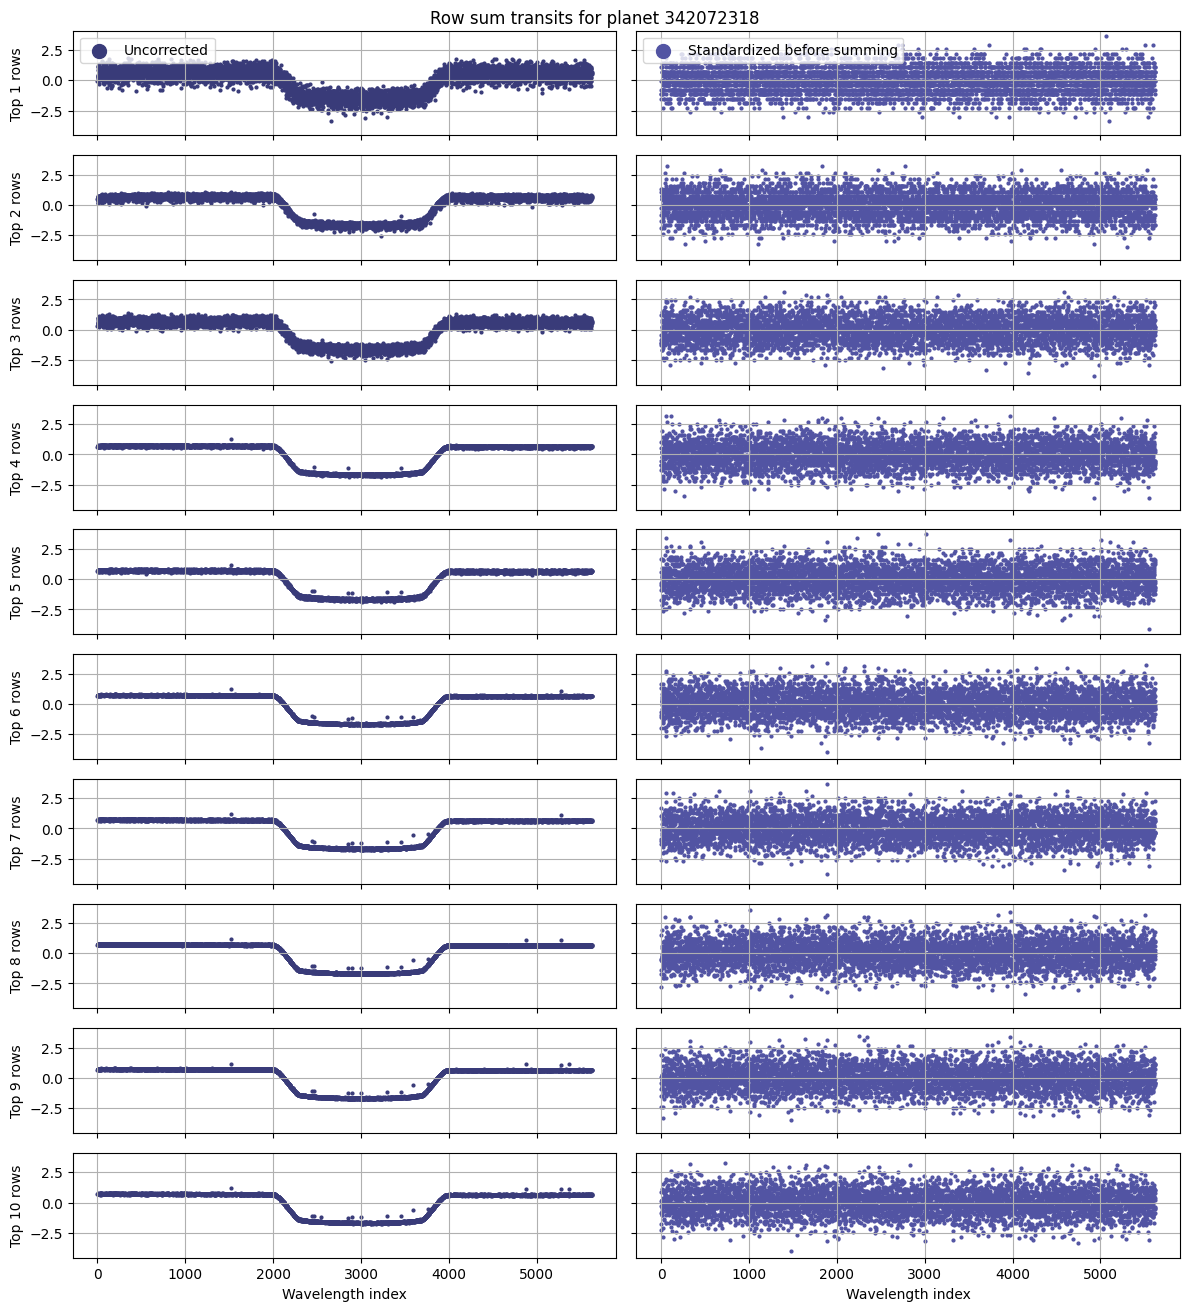

In [17]:
row_nums = [1,2,3,4,5,6,7,8,9,10]

fig, axs = plt.subplots(
    len(row_nums),
    2,
    sharex=True,
    sharey=True,
    figsize=(config.STD_FIG_WIDTH * 2,
    len(row_nums) * (config.STD_FIG_WIDTH / 4.5))
)

fig.suptitle(f'Row sum transits for planet {config.SAMPLE_PLANET}')

for i, n_rows in enumerate(row_nums):

    row_signals = corrected_airs_signal[:, top_rows[:n_rows], :]

    # Standardize each wavelength across the frames
    standardized_row_signals = (
        row_signals - np.mean(row_signals, axis=2, keepdims=True)
    ) / np.std(row_signals, axis=2, keepdims=True)

    total_rows_signal = [np.sum(frame) for frame in row_signals]
    total_standardized_rows_signal = [np.sum(frame) for frame in standardized_row_signals]
    total_rows_signal = (total_rows_signal - np.mean(total_rows_signal)) / np.std(total_rows_signal)

    total_standardized_rows_signal = (
        total_standardized_rows_signal - np.mean(total_standardized_rows_signal)
    ) / np.std(total_standardized_rows_signal)

    axs[i,0].scatter(
        range(len(total_rows_signal)),
        total_rows_signal,
        color=transit_color,
        s=4,
        label='Uncorrected'
    )
    axs[i,1].scatter(
        range(len(total_standardized_rows_signal)),
        total_standardized_rows_signal,
        color=light_blue,
        s=4,
        label='Standardized before summing'
    )
    axs[i,0].set_ylabel(f'Top {n_rows} rows')
    axs[i,0].grid()
    axs[i,1].grid()

axs[0,0].legend(loc='upper left', markerscale=5)
axs[0,1].legend(loc='upper left', markerscale=5)
axs[-1,0].set_xlabel('Wavelength index')
axs[-1,1].set_xlabel('Wavelength index')

fig.tight_layout()
fig.savefig(
    f'{figures_dir}/02.3-top_{len(row_nums)}_rows_summed_transit.jpg',
    dpi=config.STD_FIG_DPI,
    bbox_inches='tight'
)

## 9. Combined row sum plot: transits & spectra

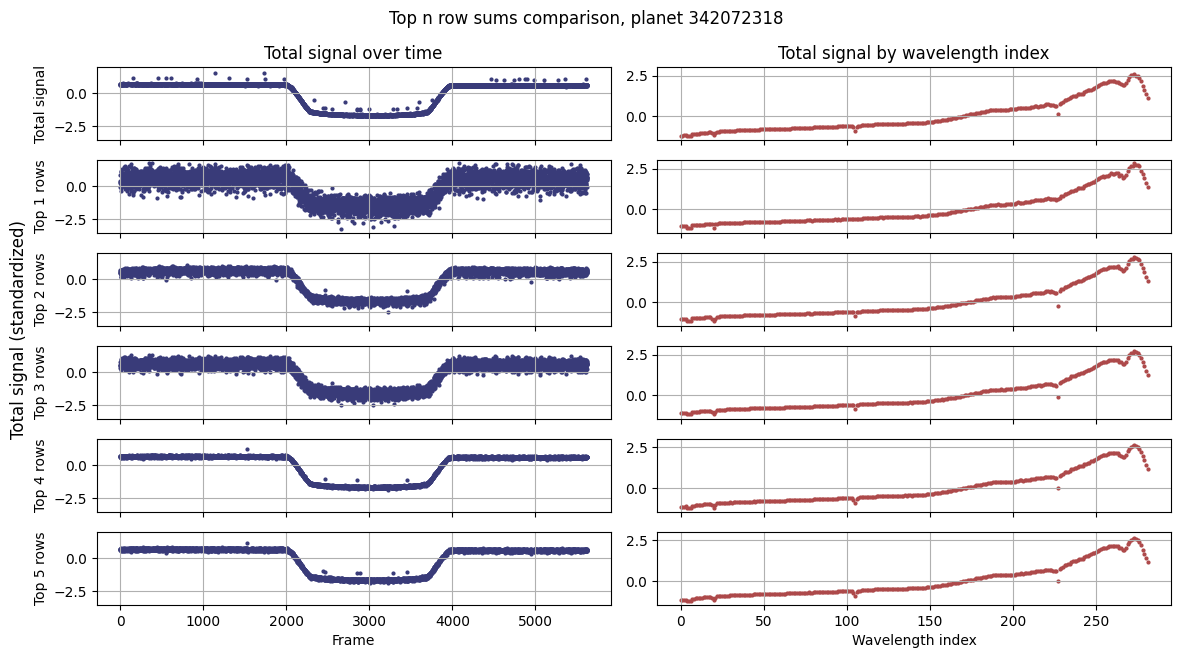

In [18]:
row_nums = [1,2,3,4,5]

fig, axs = plt.subplots(
    len(row_nums) + 1,
    2,
    sharex='col',
    sharey='col',
    figsize=(
        config.STD_FIG_WIDTH * 2,
        len(row_nums) * (config.STD_FIG_WIDTH / 4.5)
    )
)

fig.suptitle(f'Top n row sums comparison, planet {config.SAMPLE_PLANET}')
fig.supylabel('Total signal (standardized)')

standardized_total_flux = (total_flux - np.mean(total_flux)) / np.std(total_flux)

axs[0,0].set_title('Total signal over time')

axs[0,0].scatter(
    range(len(standardized_total_flux)),
    standardized_total_flux,
    color=transit_color,
    s=4
)

axs[0,0].grid()

axs[0,1].set_title('Total signal by wavelength index')

total_signal = np.sum(corrected_frame, axis=0)
standardized_total_signal = (total_signal - np.mean(total_signal)) / np.std(total_signal)

axs[0,1].scatter(
    range(len(standardized_total_signal)),
    standardized_total_signal,
    color=spectrum_color,
    s=4
)

axs[0,1].grid()

axs[0,0].set_ylabel(f'Total signal')

for i, n_rows in enumerate(row_nums):

    row_signals = corrected_airs_signal[:, top_rows[:n_rows], :]

    # Standardize each wavelength across the frames
    standardized_row_signals = (
        row_signals - np.mean(row_signals, axis=2, keepdims=True)
    ) / np.std(row_signals, axis=2, keepdims=True)

    total_rows_signal = [np.sum(frame) for frame in row_signals]
    total_standardized_rows_signal = [np.sum(frame) for frame in standardized_row_signals]
    total_rows_signal = (total_rows_signal - np.mean(total_rows_signal)) / np.std(total_rows_signal)

    axs[i+1, 0].scatter(
        range(len(total_rows_signal)),
        total_rows_signal,
        color=transit_color,
        s=4,
        label='Uncorrected'
    )

    axs[i+1, 0].grid()

    row_signals = corrected_frame[top_rows[:n_rows], :]
    row_signals = np.sum(row_signals, axis=0)
    row_signals = (row_signals - np.mean(row_signals)) / np.std(row_signals)

    axs[i+1, 1].scatter(
        range(len(row_signals)),
        row_signals,
        color=spectrum_color,
        s=4,
        label='Uncorrected'
    )

    axs[i+1, 1].grid()

    axs[i+1, 0].set_ylabel(f'Top {n_rows} rows')

axs[-1, 0].set_xlabel('Frame')
axs[-1, 1].set_xlabel('Wavelength index')

fig.tight_layout()
fig.savefig(
    f'{figures_dir}/02.3-top_{len(row_nums)}_rows_summed_transit.jpg',
    dpi=config.STD_FIG_DPI,
    bbox_inches='tight'
)

**Results**

1. Clearly don't want to standardize the rows before summing for the spectra - then we loose the transit signal.
2. For this planet at least, looks like we want to use at least the top four rows - it's not clear if there is anything to be gained by using more than that.

Before we move on, let's come up with a way to automatically select the number of rows based on a fraction or percent of signal. Imaging drawing a horizontal line on the total flux by frame y-index plot from the start of this notebook. That way we don't need to worry about loosing signal by selecting too few rows for very bright stars or vice versa.

## 10. Automated row selection

Idea is to shift the row sums so that the minimum is zero, then we can select rows by a fraction of the maximum value.

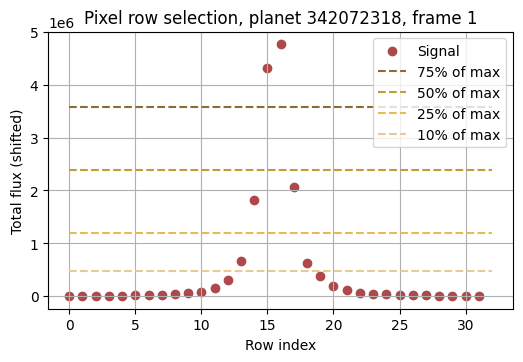

In [19]:
# Sum the frame's rows
row_sums = np.sum(corrected_frame, axis=1)

# Shift the sums so the minimum is zero
row_sums -= np.min(row_sums)
signal_range = np.max(row_sums)
inclusion_thresholds = [0.75, 0.50, 0.25, 0.10]

plt.figure(figsize=(config.STD_FIG_WIDTH, config.STD_FIG_WIDTH * 0.6))
plt.title(f'Pixel row selection, planet {config.SAMPLE_PLANET}, frame 1')

plt.scatter(
    range(len(row_sums)),
    row_sums,
    color=red,
    label='Signal'
)

for i, threshold in enumerate(inclusion_thresholds):
    plt.hlines(
        y=signal_range * threshold,
        xmin=0,
        xmax=len(row_sums),
        colors=colors[8+i],
        linestyles='dashed',
        label=f'{int(threshold*100)}% of max'
    )

plt.xlabel('Row index')
plt.ylabel('Total flux (shifted)')
plt.grid()
plt.legend()

plt.savefig(
    f'{figures_dir}/02.3-row_number_selection.jpg',
    dpi=config.STD_FIG_DPI, bbox_inches='tight'
)
plt.show()

You get the idea - this will work for any planet - we might not get a constant number of rows, but we should get a consistent - ish fraction of the signal overall signal. Our minimum sweet spot for the sample planet was 4 rows, using this cutoff method, that translates to 25% max signal inclusion threshold.